**Table of contents**<a id='toc0_'></a>    
- [Strategy](#toc1_)    
  - [Indicators](#toc1_1_)    
  - [Preprocess](#toc1_2_)    
    - [Normalise Moving Averages](#toc1_2_1_)    
- [Machine Learning](#toc2_)    
  - [First Fit](#toc2_1_)    
  - [Hypertuning # TODO](#toc2_2_)    
  - [Validate](#toc2_3_)    
- [Strategy](#toc3_)    
  - [Strategy Pipeline on ETHUSDT # TODO](#toc3_1_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
import pandas as pd
import seaborn as sns


from itertools import chain
from xgboost import XGBClassifier
from matplotlib import pyplot as plt

from sklearn.metrics import accuracy_score

from sklearn.svm import OneClassSVM 

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [2]:
df = pd.read_csv("/home/ekremezm/workspace/Coin-R/data/BTCUSDT_1h.csv")

# <a id='toc1_'></a>[Strategy](#toc0_)

## <a id='toc1_1_'></a>[Indicators](#toc0_)

In [3]:
def moving_average(prices, n):
    MA = pd.Series(prices.rolling(n, min_periods=n).mean(), name="ma_" + str(n))
    return MA

def exponential_moving_average(prices, n):
    EMA = pd.Series(prices.ewm(span=n, min_periods=n).mean(), name="ema_" + str(n))
    return EMA

def relative_strength_index(series, n):
    # Calculate daily price changes
    delta = series.diff(1).dropna()

    # Calculate gain (positive changes) and loss (negative changes)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    # Calculate average gain and average loss over the specified window
    avg_gain = gain.rolling(window=n, min_periods=1).mean()
    avg_loss = loss.rolling(window=n, min_periods=1).mean()

    # Calculate relative strength (RS)
    rs = avg_gain / avg_loss

    # Calculate RSI
    rsi = rs / (1 + rs)
    rsi = pd.Series(rsi, name="rsi_" + str(n))
    return rsi

def stochastic_oscillator(candles, n):
    S0K = pd.Series(
        (candles["Close"] - candles["Low"]) / (candles["High"] - candles["Low"]), name="S0k_" + str(n)
    )
    return S0K

def standart_deviation(series, n):
    std = pd.Series(series.rolling(n, min_periods=n).std(), name="std_" + str(n))
    return std



In [4]:
windows = [3,4,7,8,12,14,21,24,30,40,48,60]

data = df["OpenTime"]

for i in windows:
    data = pd.concat([data, moving_average(df["Close"], i)], axis = 1)
    data = pd.concat([data, exponential_moving_average(df["Close"], i)], axis = 1)
    data = pd.concat([data, relative_strength_index(df["Close"], i)], axis = 1)
    data = pd.concat([data, stochastic_oscillator(df, i)], axis = 1)

## <a id='toc1_2_'></a>[Preprocess](#toc0_)

### <a id='toc1_2_1_'></a>[Normalise Moving Averages](#toc0_)

In [5]:
for column in data.columns:
    if column.startswith("ma_") or column.startswith("ema_"):
        data[column] = (df["Close"] / data[column]) - 1

### Target Data

#### Ratio Change

In [6]:
df["ratio"] = (df["Close"].shift(-1) / df["Close"]) - 1
df = df.dropna()

#### Regression Mission to Classification Task

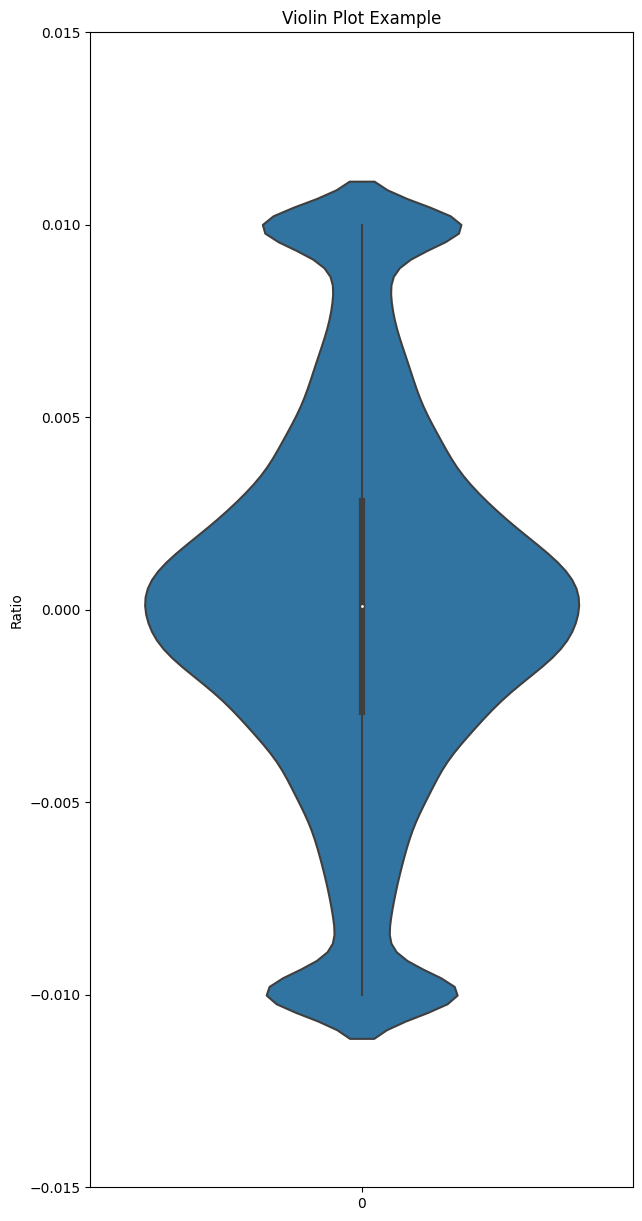

In [11]:
plt.figure(figsize=(7, 15)) 
sns.violinplot(df["ratio"] )
plt.title('Violin Plot Example')
plt.ylabel('Ratio')
# plt.ylim([-.05,.05])
plt.ylim([-.015,.015])
plt.show()

In [8]:
outlier_limit = .01
df.loc[df["ratio"] > outlier_limit, "ratio"] = outlier_limit
df.loc[df["ratio"] < -outlier_limit, "ratio"] = -outlier_limit


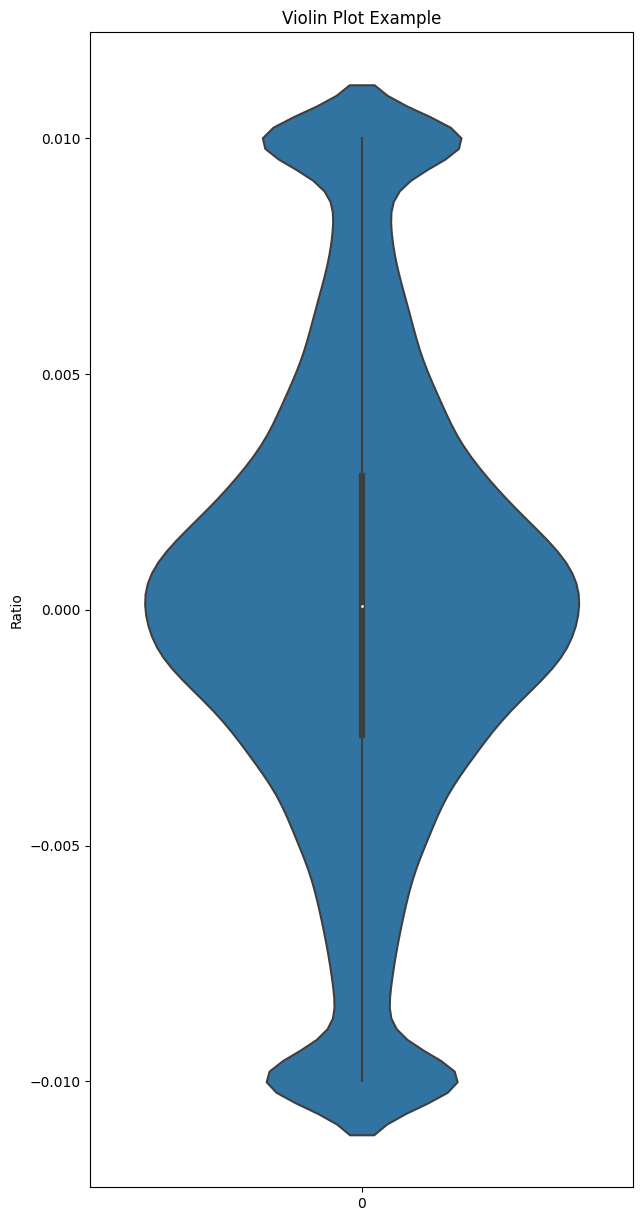

In [9]:
plt.figure(figsize=(7, 15)) 
sns.violinplot(df["ratio"] )
plt.title('Violin Plot Example')
plt.ylabel('Ratio')
plt.show()

In [ ]:
# TODO: Class changes (more and auto)
limit = 0.003
data.loc[df["ratio"] <= (-limit), "Target"] = 0
data.loc[(df["ratio"] > (-limit)) & (df["ratio"] < (limit)), "Target"] = 1
data.loc[df["ratio"] >= limit, "Target"] = 2

### Create time series

In [ ]:
time_series_data = list()
series_limit = 5

data = data.iloc[:len(data) - (len(data) % series_limit)]
data_range = range(0, len(data), series_limit)
for i in data_range:
    part = data.iloc[i:i+series_limit,]
    
    part_series = list(chain(*part.values.tolist()))
    time_series_data.append(part_series)

time_series_df = pd.DataFrame(time_series_data)

In [ ]:
time_series_df = time_series_df.dropna()
time_series_df.iloc[:,-1] = time_series_df.iloc[:,-1].astype(int)

## Train Test Split

In [ ]:
X = time_series_df.iloc[:,:-1].values.tolist()
y = time_series_df.iloc[:,-1].values.tolist()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
# X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

# <a id='toc2_'></a>[Machine Learning](#toc0_)

## <a id='toc2_1_'></a>[First Fit](#toc0_)

In [ ]:
clf = XGBClassifier(random_state=42)
clf.fit(X_train, y_train)

## <a id='toc2_2_'></a>[Hypertuning # TODO](#toc0_)

## <a id='toc2_3_'></a>[Validate](#toc0_)

In [ ]:
y_pred = clf.predict(X_test)

In [ ]:
test_accuracy = accuracy_score(y_test, y_pred)
test_precision = precision_score(y_test, y_pred, average='macro')
test_recall = recall_score(y_test, y_pred, average='macro')
test_f1 = f1_score(y_test, y_pred, average='macro')

print("Test Accuracy:", test_accuracy)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)
print("Test F1 Score:", test_f1)

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# <a id='toc3_'></a>[Strategy](#toc0_)

## <a id='toc3_1_'></a>[Strategy Pipeline on ETHUSDT # TODO](#toc0_)